In [1]:
import pandas as pd
import numpy as np
import itertools
import math
import os

from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
    from tensorflow.keras.optimizers import SGD
except:
    os.system('python3 -m pip install tensorflow==2.7')
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
    from tensorflow.keras.optimizers import SGD

# Artificial Neural Networks applied in Football Analytics II

During my project, I built different kinds of Artificial Neural Network (ANN) models in order to solve some problems and see new applications of data in sports analytics. To do so, I used TensorFlow, an open-source library for machine learning that is very optimised for this kind of models. I chose this library as it is one of the most popular ones.

As I started working with TensorFlow, I encountered a few backward-compatibility issues due to newer versions of the library not being able to run code written for older versions. Therefore, I made sure to use the same version of TensorFlow as the one used to prepare this project: 2.7 (latest stable version at the moment of writing this).

During the project, I built 3 different kinds of ANN, each to solve a different problem using a different dataset. I started by designing and training a Multilayer Perceptron (MLP) (or feedforward ANN) to compute a metric called Post-Shot Expected Goals (PSxG). Later on, I constructed a Convolutional Neural Network (CNN) to be used as an action selection model through spatial data, which is the focus of this Notebook. Finally, I designed an Autoencoder to reduce the dimensionality of a dataset consisting of aggregated player stats in order to apply clustering algorithms and find different groups of players.

It is worth noting that ANNs allow for lots of hyper-parameters to be tuned, as well as the many possible structures we can use. Finding the most appropriate design is sometimes regarded more as an art rather than a science, given that trying all possible combinations may be too power and time consuming. Due to the time limitation of my project, I only tried to find performance improvements by applying some tweaks on the model for the first exercise. For the rest, I focused on how can the different network structures be helpful given their nature. I didn't use methods such as cross-validation for model selection due to time limitations, but I am aware that these procedures should be used when dealing with real-world problems.

The next cell presents a group of methods that I will use to train and evaluate the NN models I create. This will be helpful to allow changing model parameters and configurations in a simplified manner. The methods are pretty straight-forward.

In [2]:
def train_and_evaluate_model(m, _data, loss="mean_squared_error", metrics=["accuracy", "mean_squared_error"], learning_rate=0.1, momentum=0.0, epochs=50, batch_size=64, verbose=1):
    evaluate_model(train_model(m, _data, loss, metrics, learning_rate, momentum, epochs, batch_size, verbose), _data, metrics)

def train_model(m, _data, loss="mean_squared_error", metrics=["accuracy", "mean_squared_error"], learning_rate=0.1, momentum=0.0, epochs=50, batch_size=64, verbose=1):
    tf.random.set_seed(1234)
    m.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss=loss, metrics=metrics)
    m.fit(_data["X_train"], _data["y_train"], epochs=epochs , batch_size=batch_size, validation_split=0.2, verbose=verbose)
    return m

def evaluate_model(m, _data, metrics):
    r = m.evaluate(_data["X_test"], _data["y_test"], verbose=0)
    print("\n" + " | ".join("{0}: {1}".format(metric, value) for metric, value in zip(metrics, r[1:])))

## 2. Predicting shots with Convolutional Neural Networks

CNNs are very useful when we are dealing with input that corresponds to images. This is because this kind of NNs are good at finding patterns among predictor variables that situated closely to each other. In the case of images, since the input is the values of their pixels, finding patterns within the values of pixels that are nearby will be key. For now though, I have still not worked with image-like data related to sports. But I can do so if, for example, I transform spatial data into aggregation matrices of fixed size.

In [3]:
df_events = pd.read_csv("data/df_events.csv")
df_events.head()

,event_type,norm_origin_pos_x,norm_origin_pos_y,possession_image,opposition_image
0,Pass,0.641838,0.641445,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,Pass,0.703385,0.300251,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."
2,Pass,0.569177,0.849875,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,Pass,0.043962,0.573206,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Drive,0.393331,0.440442,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,..."


I loaded a dataframe that contained spatial information recorded at the moment each event present was produced. The dataframe had information such as the type of event, the normalized position where it happened in the field, and two different matrices that represented the positions of the players that either belong to the team that was in possession or the opposition. However, these matrices were coded as sparse matrices of 34x52, where the bins with 1 (or more) show that there was 1 (or more) players in that part of the field. Note that the field size was 105x68m (68x105 seen vertically), so each bin of the matrix represented a region of 2 squared meters.

Both the array and matrix columns were not read correctly by pandas from CSV files (they were read as strings). So I ran the following cell to transform them back to ndarrays. It took a few minutes to run...

In [4]:
df_events['possession_image'] = df_events['possession_image'].apply(lambda x: np.array(eval(x)))
df_events['opposition_image'] = df_events['opposition_image'].apply(lambda x: np.array(eval(x)))

My goal was to build a CNN capable of predicting the event type, given all the spatial data. But before doing that, I needed to convert the original position of the event into the same format as the positions of the players. I transformed each origin position into a 34x52 ndarray full of zeros but for the bin where that position would fall into (which was a 1). I took into account that the matrix was transposed, so its first axis corresponded to the pos_y and the second to the pos_x.

In [5]:
from scipy.sparse import csr_matrix

# Define the shape of the sparse matrix
output_shape = (34, 52)

# Define a function to create the ndarray for each row
def create_sparse_matrix(row):
    # Extract the origin position coordinates from the row
    x_pos = int(np.clip(row['norm_origin_pos_x'], 0, 0.9999999) * output_shape[1])
    y_pos = int(np.clip(row['norm_origin_pos_y'], 0, 0.9999999) * output_shape[0])

    # Create the ndarray with a 1 at the specified coordinate
    ndarray = np.zeros(output_shape)
    ndarray[y_pos, x_pos] = 1

    return ndarray

# There are some rows with values < 0. I transform into positive instead of 0 as some have values far from 0 (e.g. -0.5)
df_events['norm_origin_pos_x'] = np.where(df_events['norm_origin_pos_x']<0,-df_events['norm_origin_pos_x'],df_events['norm_origin_pos_x'])
df_events['norm_origin_pos_y'] = np.where(df_events['norm_origin_pos_y']<0,-df_events['norm_origin_pos_y'],df_events['norm_origin_pos_y'])

# There are some rows with values > 1. I transform into 1
df_events['norm_origin_pos_x'] = np.where(df_events['norm_origin_pos_x']>1,1,df_events['norm_origin_pos_x'])
df_events['norm_origin_pos_y'] = np.where(df_events['norm_origin_pos_y']>1,1,df_events['norm_origin_pos_y'])

df_events['ball_image'] = df_events.apply(lambda row: create_sparse_matrix(row), axis=1)

Once I had prepared the predictor variables, it was time to prepare the response variables. I applied a one-hot encoding to the event_type to make sure that each of the following variables was 1 when it corresponded and 0 for the rest.

In [6]:
df_events['is_pass'] = np.where(df_events['event_type']=='Pass',1,0)
df_events['is_drive'] = np.where(df_events['event_type']=='Drive',1,0)
df_events['is_shot'] = np.where(df_events['event_type']=='Shot',1,0)

Let's now put together each group of variables into 2 different multidimensional ndarrays.

In [7]:
X = np.stack(df_events.apply(lambda x: np.dstack([x["possession_image"], x["opposition_image"], x["ball_image"]]), axis=1))
y = df_events[["is_pass", "is_drive", "is_shot"]].values

In [8]:
X.shape, y.shape

((99334, 34, 52, 3), (99334, 3))

And let's split the multidimensional arrays into train and test sets.

In [9]:
indexes = list(StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=1234).split(X, y))[0]
train_index, test_index = indexes
X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

In [10]:
np.mean(y_train, axis=0), np.mean(y_test, axis=0)

(array([0.88488874, 0.09529247, 0.01981879]),
 array([0.88490284, 0.09529911, 0.01979805]))

Again, I saw that the response variables were very unbalanced. So, I used stratified splitting to make sure that both sets contained the same proportions. Then, I normalized the predictor variables so that all values were between 0 and 1. To do so, I just divided the matrices by the value of the bin with the maximum value.

In [11]:
np.max(X_train)

3.0

In [12]:
data = {"X_train": X_train/np.max(X_train), "y_train": y_train, "X_test": X_test/np.max(X_train), "y_test": y_test}

As mentioned earlier, not much detail was given about the structure of the Convolutional Neural Network. I applied a single convolutional layer, with a subsequent max pooling layer. After that, I flattened the input to apply 2 other dense layers: the hidden one and the output. Note that this time, since I was performing a 3-class classification, I needed 3 neurons at the last layer.

I kept using the Cross Entropy as the loss function, though this time I used the one for multi-class classification instead of the one for binary classification. I also changed the evaluation metrics to use others more appropriate for this classification problem.

I trained the model, which also took a while...

In [13]:
model = Sequential([
    # convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(34, 52, 3)),
    # max pooling layer
    MaxPooling2D((2, 2)),
    # flatten layer
    Flatten(),
    # hidden layer
    Dense(32, activation='relu'),
    # output layer
    Dense(3, activation='sigmoid'),
])
train_and_evaluate_model(model, data, loss='categorical_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Epoch 1/50
832/832 [==============================] - 78s 86ms/step - loss: 0.4186 - precision: 0.8836 - recall: 0.8833 - val_loss: 0.4365 - val_precision: 0.8872 - val_recall: 0.8872
Epoch 2/50
832/832 [==============================] - 57s 69ms/step - loss: 0.4077 - precision: 0.8843 - recall: 0.8843 - val_loss: 0.3931 - val_precision: 0.8872 - val_recall: 0.8872
Epoch 3/50
832/832 [==============================] - 51s 61ms/step - loss: 0.3924 - precision: 0.8755 - recall: 0.8857 - val_loss: 0.3777 - val_precision: 0.8021 - val_recall: 0.9014
Epoch 4/50
832/832 [==============================] - 50s 60ms/step - loss: 0.3801 - precision: 0.6776 - recall: 0.9253 - val_loss: 0.3717 - val_precision: 0.6025 - val_recall: 0.9440
Epoch 5/50
832/832 [==============================] - 54s 65ms/step - loss: 0.3733 - precision: 0.6005 - recall: 0.9493 - val_loss: 0.3674 - val_precision: 0.5831 - val_recall: 0.9533
Epoch 6/50
832/832 [==============================] - 48s 58ms/step - loss: 0.36

832/832 [==============================] - 32s 39ms/step - loss: 0.0042 - precision: 0.6304 - recall: 1.0000 - val_loss: 0.9783 - val_precision: 0.5998 - val_recall: 0.9586
Epoch 46/50
832/832 [==============================] - 33s 39ms/step - loss: 0.0037 - precision: 0.6328 - recall: 1.0000 - val_loss: 0.9922 - val_precision: 0.5983 - val_recall: 0.9577
Epoch 47/50
832/832 [==============================] - 33s 39ms/step - loss: 0.0034 - precision: 0.6345 - recall: 1.0000 - val_loss: 1.0069 - val_precision: 0.5988 - val_recall: 0.9579
Epoch 48/50
832/832 [==============================] - 33s 39ms/step - loss: 0.0030 - precision: 0.6358 - recall: 1.0000 - val_loss: 1.0276 - val_precision: 0.6013 - val_recall: 0.9576
Epoch 49/50
832/832 [==============================] - 33s 39ms/step - loss: 0.0028 - precision: 0.6375 - recall: 1.0000 - val_loss: 1.0370 - val_precision: 0.6027 - val_recall: 0.9569
Epoch 50/50
832/832 [==============================] - 34s 41ms/step - loss: 0.0026 - p

There is a big difference between the values of both metrics evaluated, precision and recall. Each of them have different situations where the model would be good for and others it would not.

Precision and recall are two commonly used metrics to evaluate the performance of a classification model. Precision measures the proportion of predicted positive instances that are actually positive, while recall measures the proportion of actual positive instances that are correctly predicted as positive.

In the context of predicting if a shooting action is going to happen, precision would indicate the proportion of predicted shots that actually occur, while recall would indicate the proportion of actual shots that the model is able to detect.

A high precision would mean that the model is good at identifying instances where a shot action is likely to happen, and it is unlikely to produce false positives. On the other hand, a high recall would mean that the model is good at identifying all instances of shots that occur, even if it produces some false positives.

In general, for predicting a shot action, a model with both high precision and high recall would be ideal, but it is important to weigh the costs of false positives and false negatives against each other, depending on the specific use case. 

If the precision is high, but the recall is low, it means that the model is able to identify shots accurately, but it is missing a significant number of actual shots. In our use case this would mean that the model is conservative and only predicts the very clear shots even if there are some shots not being identified.

If the recall is high, but the precision is low, it means that the model is identifying many instances as shots, but many of those instances are not actually shootings. In this case we have such model where the recall is high, but the precision is low (Precision: 0.5850821733474731 Recall: 0.9636069536209106). So there are a lot of instances where the model predicts with high probability a shot will happen when it did not happen. The model accurately recovers all instances where a shot happened (good) with the consequence that a lot of non-shot actions are classified as shots (bad).

The results of the model are not great. Trying different configurations of the network would probably help, but most of all, the best improvement would be adding different kind of data as the input. Using just the locations is probably difficult for any model to predict the next action. Adding player speed and contextual information would probably help a lot. In this part I had limited the input data for simplicity and to avoid longer processing and training times.

Following the methodology used in the previous exercise, I plotted a heatmap of the field that indicates where it was more probable for a shot to be produced. As before, I predicted the probabilities for the whole dataset and, for each bin, computed the mean shot probability for all the events whose origin position fell onto that bin.

In [85]:
y_pred = pd.DataFrame(model.predict(X)[:,2],columns=['is_shot_pred'])
y_pred=pd.merge(df_events[['norm_origin_pos_x','norm_origin_pos_y']],y_pred,how = 'left',left_index = True, right_index = True).dropna()

In [86]:
# Calculate the row and column indices for each coordinate
y_pred['norm_origin_pos_y'] = (np.clip(y_pred['norm_origin_pos_y'], 0, 0.999999) * output_shape[0]).astype(int)
y_pred['norm_origin_pos_x'] = (np.clip(y_pred['norm_origin_pos_x'], 0, 0.999999) * output_shape[1]).astype(int)

y_pred_group = y_pred.groupby(['norm_origin_pos_x','norm_origin_pos_y']).mean()#.reset_index()
hist = y_pred_group.pivot_table(values='is_shot_pred', index="norm_origin_pos_x", columns='norm_origin_pos_y')

The code below provides a way for drawing a 2D football field. I used it to show a useful visual evaluation obtained from the model.

In [122]:
import matplotlib.patches as patches

ww = 105
hh = 68

# transform [0,1] range points to meters
def point_to_meters(p, width=ww, height=hh):
    return np.array([p[0] * width, p[1] * height])


# transform meters range points to [0,1] range points
def meters_to_points(p,  width=ww, height=hh):
    return np.array([p[0] / float(width), p[1] / float(height)])


def draw_field(fig_size=8, lines_color="#bcbcbc", background_color="white"):
    """
    Draw a 2D football field
    """
    ratio = ww / float(hh)
    f, ax = plt.subplots(1, 1, figsize=(fig_size * ratio, fig_size), dpi=100)

    ax.add_patch(patches.Rectangle((0, 0), ww, hh, color=background_color, alpha=0))

    line_pts = [
        [point_to_meters([0, 0]), point_to_meters([0, 1])],
        [point_to_meters([1, 0]), point_to_meters([1, 1])],
        [point_to_meters([0, 1]), point_to_meters([1, 1])],  
        [point_to_meters([0, 0]), point_to_meters([1, 0])],
    ]

    for line_pt in line_pts:
        ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-', alpha=0.8,
                lw=1.5, zorder=2, color=lines_color)

    line_pts = [
        [point_to_meters([0.5, 0]), point_to_meters([0.5, 1])],

        [[0, 24.85], [0, 2.85]],
        [[0, 13.85], [16.5, 13.85]],
        [[0, 54.15], [16.5, 54.15]],
        [[16.5, 13.85], [16.5, 54.15]],

        [[0, 24.85], [5.5, 24.85]],
        [[0, 43.15], [5.5, 43.15]],
        [[5.5, 24.85], [5.5, 43.15]],

        [[105, 24.85], [105, 2.85]],
        [[105, 13.85], [88.5, 13.85]],
        [[105, 54.15], [88.5, 54.15]],
        [[88.5, 13.85], [88.5, 54.15]],

        [[105, 24.85], [99.5, 24.85]],
        [[105, 43.15], [99.5, 43.15]],
        [[99.5, 24.85], [99.5, 43.14]]
    ]

    for line_pt in line_pts:
        ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
                alpha=0.8, lw=1.5, zorder=2, color=lines_color)
    
    # Circles
    ax.add_patch(patches.Wedge((94.0, 34.0), 9, 128, 232, fill=True, edgecolor=lines_color,
                               facecolor=lines_color, zorder=4, width=0.02))

    ax.add_patch(patches.Wedge((11.0, 34.0), 9, 308, 52, fill=True, edgecolor=lines_color,
                               facecolor=lines_color, zorder=4, width=0.02))

    ax.add_patch(patches.Wedge((52.5, 34), 9.5, 0, 360, fill=True, edgecolor=lines_color,
                               facecolor=lines_color, zorder=4, width=0.02))

    plt.axis('off')
    
    return ax

Text(0.5, 1.0, 'Goal heatmap')

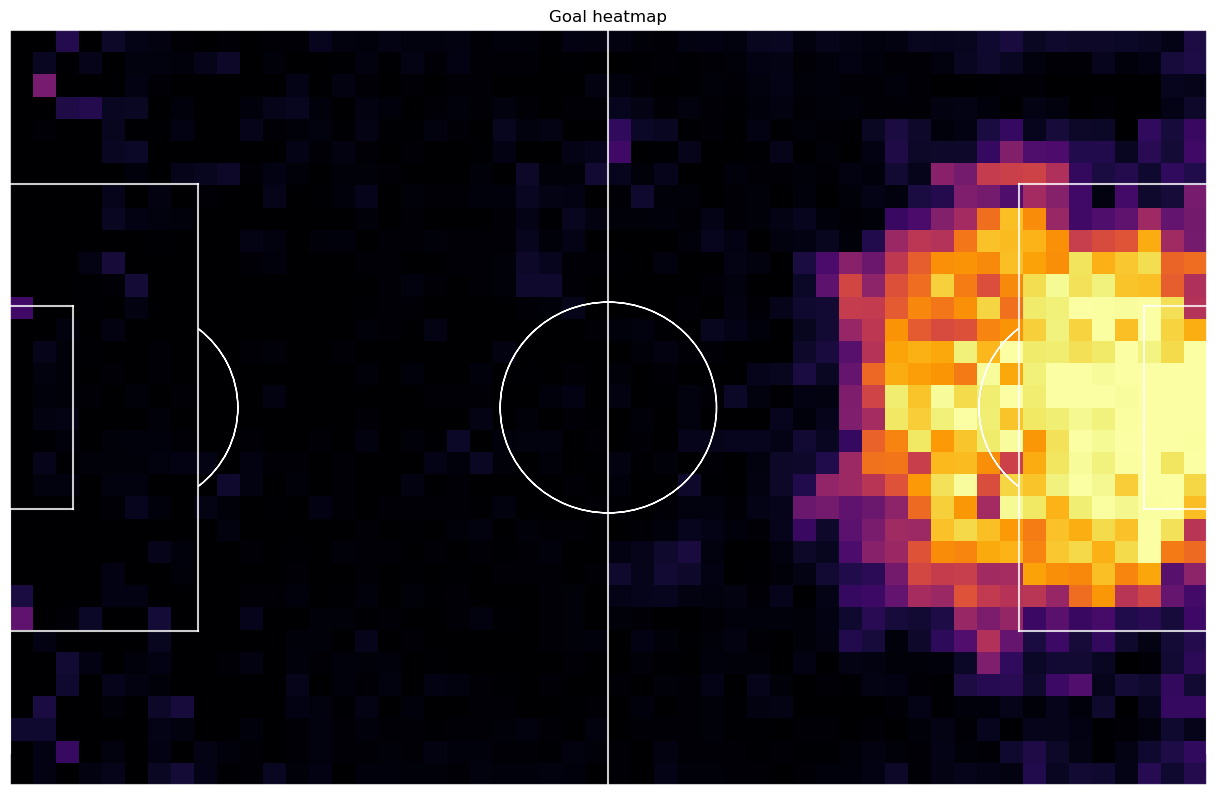

In [158]:
# We plot the pitch with the shot heatmap prediction from the model
ax = draw_field(fig_size=10, lines_color="white", background_color="grey")
im = ax.imshow(hist.T, cmap="inferno",origin='lower', aspect='auto', extent=[0, ww, 0, hh])
ax.set_title("Goal heatmap")
# fig.colorbar(im, ax=ax, orientation='horizontal')